In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.gridspec as gridspec
import cv2
import matplotlib.image as mpimg
import os
import pickle
import pandas as pd
from sklearn.utils import shuffle
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline

## Acquisition Functions

In [2]:
def createDataFrame(data_path):
    """
    input: data_path: path to data
    return: data frame
    """
    data_frame = pd.read_csv(data_path)
    data_frame.columns = ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
    return data_frame

### Split data into left turns, right turns, center (no turns)

In [3]:
def createTrainingDataPathsCLR(df, prefix_path):
    """
    creates training data and training labels/ measurements from a data frame
    inputs:
    df: pandas DataFrame object
    start: starting row to grab data
    end: ending row to grab data
    correction_factor: factor to correct steering angles
    """    
    # Turn types
    center_turns = []
    left_turns = []
    right_turns = []
    
    
    abs_path_to_IMG = os.path.abspath(prefix_path)
    for idx, row in df.iterrows():
        center_image_cam = os.path.join(abs_path_to_IMG, row['center'].strip())
        left_image_cam = os.path.join(abs_path_to_IMG, row['left'].strip())
        right_image_cam = os.path.join(abs_path_to_IMG, row['right'].strip())
        steering_angle = row['steering']
        
        # Right image condition
        if steering_angle > 0.125:
            right_turns.append([center_image_cam, left_image_cam, right_image_cam, steering_angle])
            
        # This is a left image
        elif steering_angle < -1 * 0.125:
            left_turns.append([center_image_cam, left_image_cam, right_image_cam, steering_angle])
            
        # This is a center image
        else:
        # center images
            center_turns.append([center_image_cam, left_image_cam, right_image_cam, steering_angle])
        
    return (center_turns, left_turns, right_turns)

In [4]:
def makeMore(dataArray, amount):
    for i in range(len(dataArray)):
        for j in range(amount):                                     # np.random.uniform(-0.03, 0.03)
            dataArray.append([dataArray[i][0], dataArray[i][1], dataArray[i][2], dataArray[i][3]])
    return dataArray

## Prepare training data

### Create data from udacity

#### Create Data Frame

In [5]:
data_pd_udacity = createDataFrame('data/driving_log.csv')
columns = ['center', 'left', 'right', 'steering']

#### Create centers_turns, left_turns, right_turns

In [6]:
(center_turns_udacity,
left_turns_udacity,
right_turns_udacity) = createTrainingDataPathsCLR(data_pd_udacity, 'data/')

#### Make more copies

In [7]:
center_turns_udacity = makeMore(center_turns_udacity, 5)
left_turns_udacity = makeMore(left_turns_udacity, 18)
right_turns_udacity = makeMore(right_turns_udacity, 12)

In [8]:
df_center_udacity = pd.DataFrame(center_turns_udacity, columns = columns)
df_left_udacity = pd.DataFrame(left_turns_udacity, columns = columns)
df_right_udacity = pd.DataFrame(right_turns_udacity, columns = columns)

print('df_center_udacity.index: ', len(df_center_udacity.index))
print('df_left_udacity.index: ', len(df_left_udacity.index))
print('df_right_udacity.index: ', len(df_right_udacity.index))


df_center_udacity.index:  36714
df_left_udacity.index:  16131
df_right_udacity.index:  13884


#### Histogram Visualization

In [9]:
# plt.hist(np.asarray(df_center_udacity['steering'], dtype=np.float32))
# plt.hist(np.asarray(df_center_udacity['steering'], dtype=np.float32),bins=100,range=(-0.2,0.2),facecolor="r", histtype = 'step')

In [10]:
# plt.hist(np.asarray(df_left_udacity['steering'], dtype=np.float32))
# plt.hist(np.asarray(df_left_udacity['steering'], dtype=np.float32),bins=100,range=(-0.6,0.15),facecolor="r", histtype = 'step')

In [11]:
# plt.hist(np.asarray(df_right_udacity['steering'], dtype=np.float32))
# plt.hist(np.asarray(df_right_udacity['steering'], dtype=np.float32),bins=100,range=(0.15,0.6),facecolor="r", histtype = 'step')

#### Shuffle

In [12]:
df_center_udacity = shuffle(df_center_udacity)
df_left_udacity = shuffle(df_left_udacity)
df_right_udacity = shuffle(df_right_udacity)

#### Concat

In [13]:
frames_to_concat_udacity = [df_center_udacity, df_left_udacity, df_right_udacity]
df_udacity = pd.concat(frames_to_concat_udacity, axis = 0, join = 'outer', ignore_index=False)

### Create data from recovery

#### Create Data Frame

In [14]:
data_pd_recovery = createDataFrame('annie_recovery/driving_log_recovery.csv')
columns = ['center', 'left', 'right', 'steering']

#### Create centers_turns, left_turns, right_turns

In [15]:
(center_turns_recovery,
left_turns_recovery,
right_turns_recovery) = createTrainingDataPathsCLR(data_pd_recovery, 'annie_recovery/')

#### Make more copies

In [16]:
center_turns_recovery = makeMore(center_turns_recovery, 5)
left_turns_recovery = makeMore(left_turns_recovery, 18)
right_turns_recovery = makeMore(right_turns_recovery, 12)

In [17]:
df_center_recovery = pd.DataFrame(center_turns_recovery, columns = columns)
df_left_recovery = pd.DataFrame(left_turns_recovery, columns = columns)
df_right_recovery= pd.DataFrame(right_turns_recovery, columns = columns)

In [18]:
print('df_center_recovery.index: ', len(df_center_recovery.index))
print('df_center_recovery.index: ', len(df_left_recovery.index))
print('df_center_recovery.index: ', len(df_right_recovery.index))

df_center_recovery.index:  4308
df_center_recovery.index:  6213
df_center_recovery.index:  3926


#### Histogram Visualization

In [19]:
# plt.hist(np.asarray(df_center_recovery['steering'], dtype=np.float32))
# plt.hist(np.asarray(df_center_recovery['steering'], dtype=np.float32),bins=100,range=(-0.2,0.2),facecolor="r", histtype = 'step')

In [20]:
# plt.hist(np.asarray(df_left_recovery['steering'], dtype=np.float32))
# plt.hist(np.asarray(df_left_recovery['steering'], dtype=np.float32),bins=100,range=(-0.2,0.2),facecolor="r", histtype = 'step')

In [21]:
# plt.hist(np.asarray(df_right_recovery['steering'], dtype=np.float32))
# plt.hist(np.asarray(df_right_recovery['steering'], dtype=np.float32),bins=100,range=(-0.2,0.2),facecolor="r", histtype = 'step')

#### Shuffle

In [22]:
df_center_recovery = shuffle(df_center_recovery)
df_left_recovery = shuffle(df_left_recovery)
df_right_recovery = shuffle(df_right_recovery)

#### Concat

In [23]:
frames_to_concat_recovery = [df_center_recovery, df_left_recovery, df_right_recovery]
df_recovery = pd.concat(frames_to_concat_recovery, axis = 0, join = 'outer', ignore_index=False)

### Concat both dataframes together (Udacity + Recovery)

In [24]:
frames = [df_udacity, df_recovery]
train_data = pd.concat(frames, axis = 0, join = 'outer', ignore_index=False)

In [25]:
print('train_data size: ', len(train_data.index))

train_data size:  81176


### RANDOM TEST

In [26]:
# random selection
data = train_data
random_images = []
for i in range(20):
    idx = np.random.randint(len(data))
    row = data.iloc[[idx]].reset_index()
    x, y = preprocess_image_from_path(row['center'].values[0], row['steering'].values[0])
    random_images.append((x, y))
    
plt.figure(figsize=(16, 10))
gs1 = gridspec.GridSpec(4, 5)
gs1.update(wspace = 0.01, hspace = 0.01)
for idx, image in enumerate(random_images):
    angle = 'ang: ' + str(image[1]) 
    ax1 = plt.subplot(gs1[idx])
    ax1.axis('off')
    plt.title(angle)
    plt.imshow(image[0])
plt.show()

NameError: name 'preprocess_image_from_path' is not defined

### Shuffle again

In [27]:
train_data = shuffle(train_data)

### Train Test Split

In [28]:
train_data, valid_data = train_test_split(train_data, test_size = 0.2)
print('train_data size: ', len(train_data.index))
print('valid_data size: ', len(valid_data.index))

train_data size:  64940
valid_data size:  16236


#### Histogram of steering angles training data

(array([  1.28300000e+03,   4.70000000e+01,   2.90000000e+01,
          3.00000000e+01,   6.30000000e+01,   0.00000000e+00,
          4.70000000e+01,   1.70000000e+01,   4.50000000e+01,
          9.50000000e+01,   4.80000000e+01,   6.50000000e+01,
          4.60000000e+01,   4.50000000e+01,   9.10000000e+01,
          9.10000000e+01,   1.25000000e+02,   1.04000000e+02,
          5.20000000e+01,   8.00000000e+01,   4.10000000e+01,
          1.80000000e+01,   7.90000000e+01,   1.10000000e+02,
          1.84000000e+02,   2.24000000e+02,   1.11000000e+02,
          3.95000000e+02,   3.31000000e+02,   4.19000000e+02,
          4.36000000e+02,   3.07000000e+02,   2.91000000e+02,
          3.35000000e+02,   4.89000000e+02,   1.42900000e+03,
          8.55000000e+02,   6.27000000e+02,   1.34700000e+03,
          1.13500000e+03,   4.73000000e+02,   9.72000000e+02,
          3.58300000e+03,   1.26000000e+03,   4.74000000e+02,
          5.13000000e+02,   1.37300000e+03,   1.29100000e+03,
        

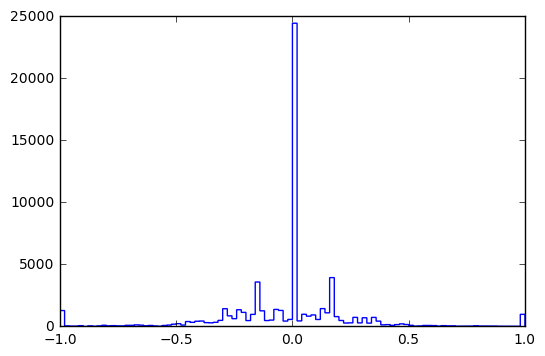

In [29]:
plt.hist(np.asarray(train_data['steering'], dtype=np.float32),bins=100,range=(-1,1),facecolor="r", histtype = 'step')

## Preprocess

In [30]:
def lateral_shift(image, ang):
    pass

In [31]:
def flip_image(image, ang):
    image = np.fliplr(image)
    ang = -1 * ang
    return (image, ang)

In [32]:
def change_brightness(image):
    bright_factor = 0.25 + np.random.uniform()
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb
    
    

In [33]:
def preprocess_image(image):
    """
    Preprocess image, 
    input: image (original shape)
    output: image (shape is (220, 66, 3) )
    """    
    image = change_brightness(image)
    # crop shape
    image = image[image.shape[0] * 0.34:image.shape[0] * 0.875,:,:]
    # resize to (66, 220)
    img = cv2.resize(image, (220, 66), interpolation=cv2.INTER_AREA)
    return img


In [34]:
def preprocess_image_valid_from_path(image_path, steering_angle):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess_image(img)
    return img, steering_angle

In [35]:
def preprocess_image_from_path(image_path, steering_angle):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # flip and reassign
    random_flip_factor = np.random.randint(2)
    if random_flip_factor == 0:
        img, steering_angle = flip_image(img, steering_angle)
    
        
    img = preprocess_image(img)
    return img, steering_angle

## Generator

Here I created two generators, one for training data and one for validation data. In the training generator we create batches of 32 for each training sample. Therefore if I have `samples_per_epoch = 10` that means for each of those samples I yield 32 images from the training generator. I did this because it allows me to have control over what the batches turn out to be. In this case [ADD HERE]```add here I will add a probability function to pass a certain image path to the processor```

In [36]:

# def generate_training_data(X_train, y_train, batch_size):
#     """
#     We create a loop through out data and 
#     send out an individual row in the dataframe to preprocess_image_from_path, 
#     which is then sent to preprocess_image
#     inputs: 
#     X_train: numpy array of X_training data (image paths),
#     y_train: numpy array of measurements (steering angles)
#     batch_size: batch sizes, size to make each batch
#     returns a yield (image_batch, label_batch)
#     """
#     image_batch = np.zeros((batch_size, 66, 220, 3)) # nvidia input params
#     label_batch = np.zeros((batch_size))
#     while True:
#         for i in range(batch_size):
            
#             idx = np.random.randint(len(X_train))
#             x, y = preprocess_image_from_path(X_train[idx], y_train[idx])
            
            
#             image_batch[i] = x
#             label_batch[i] = y

#         yield image_batch, label_batch

In [37]:
# def generate_validation_data(X_valid, y_valid):
#     while True:
#         for idx in range(len(X_valid)):
#             img, angle = preprocess_image_valid_from_path(X_valid[idx], y_valid[idx])
#             img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
#             angle = np.array([[angle]])
#             yield img, angle

### OLD GENERATOR (USES DATAFRAME)

In [38]:

def generate_training_data(data, batch_size = 32):
    """
    We create a loop through out data and 
    send out an individual row in the dataframe to preprocess_image_from_path, 
    which is then sent to preprocess_image
    inputs: 
    data: pandas DataFrame
    batch_size: batch sizes, size to make each batch
    returns a yield a batch of (image_batch, label_batch)
    """
    # TODO increase batch size to account for possible left, right, or center cam image
    # TODO add correction factor possibility to 
    
    image_batch = np.zeros((batch_size, 66, 220, 3)) # nvidia input params
    label_batch = np.zeros((batch_size))
    while True:
        for i in range(batch_size):
            idx = np.random.randint(len(data))
            row = data.iloc[[idx]].reset_index()
            x, y = preprocess_image_from_path(row['center'].values[0], row['steering'].values[0])
            
            # added to deal with left and right images =====
#             if np.random.randint(3) == 0
#                 x, y = preprocess_image_from_path(row['center'].values[0], row['steering'].values[0])
            
#             if np.random.randint(3) == 1:
#                 # 33% change to give left image and + correction_factor
#                 x, y = preprocess_image_from_path(row['left'].values[0], row['steering'] + 0.125)
                
#             if np.random.randint(3) == 2:
#                 # 33% change to give right image ajdn - correction_factor
#                 x, y = preprocess_image_from_path(row['right'].values[0], row['steering'] - 0.125)
            
            
            # added ======
            image_batch[i] = x
            label_batch[i] = y
        yield shuffle(image_batch, label_batch)
    
def generate_validation_data(data):
    """
    data: center camera images only, because thats what we observe (dataframe)
    yields: one image, angle
    """
    while True:
        for idx in range(len(data)):
            row = data.iloc[[idx]].reset_index()
            img, angle = preprocess_image_valid_from_path(row['center'].values[0], row['steering'].values[0])
            img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
            angle = np.array([[angle]])
            yield img, angle
            

## Network

#### I chose to use Nvidia's network architecture. Input (220 x 66 sized image) output (1 steering angle)

I chose to use the Nvidia model architecture which can be found [here add link]
I used ELu's because they push mean unit activation functions closer to zero [https://arxiv.org/pdf/1511.07289v1.pdf]

In [39]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU
from keras.optimizers import Adam
tf.python.control_flow_ops = tf


N_img_height = 66
N_img_width = 220
N_img_channels = 3
def nvidia_model():
    inputShape = (N_img_height, N_img_width, N_img_channels)

    model = Sequential()
    # normalization
    
    # normalize only the S in HSV
    model.add(Lambda(lambda x: x/ 127.5 - 1, input_shape = (66, 220, 3)))
    # cropping 70 off top 25 off bottom
    # model.add(Cropping2D(cropping=((70,25), (0, 0)))) Probably going to do cropping in my process

    # subsample is strides
    model.add(Convolution2D(24, 5, 5, 
                            subsample=(2,2), 
                            border_mode = 'valid',
                            init = 'he_normal',
                            name = 'conv1'))
    
    model.add(ELU())    
    model.add(Convolution2D(36, 5, 5, 
                            subsample=(2,2), 
                            border_mode = 'valid',
                            init = 'he_normal',
                            name = 'conv2'))
    
    model.add(ELU())    
    model.add(Convolution2D(48, 5, 5, 
                            subsample=(2,2), 
                            border_mode = 'valid',
                            init = 'he_normal',
                            name = 'conv3'))
    model.add(ELU())
    model.add(Convolution2D(64, 3, 3, 
                            subsample = (1,1), 
                            border_mode = 'valid',
                            init = 'he_normal', #gaussian init
                            name = 'conv4'))
    
    model.add(ELU())              
    model.add(Convolution2D(64, 3, 3, 
                            subsample= (1,1), 
                            border_mode = 'valid',
                            init = 'he_normal',
                            name = 'conv5'))
              
              
    model.add(Flatten(name = 'flatten'))
    model.add(ELU())
    model.add(Dense(100, init = 'he_normal', name = 'fc1'))
    model.add(ELU())
    model.add(Dense(50, init = 'he_normal', name = 'fc2'))
    model.add(ELU())
    model.add(Dense(10, init = 'he_normal', name = 'fc3'))
    model.add(ELU())
    
    # do not put activation at the end because we want to exact output, not a class identifier
    model.add(Dense(1, name = 'output', init = 'he_normal'))
    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = adam, loss = 'mse')

    return model


Using TensorFlow backend.


In [40]:
val_size = len(valid_data.index)
valid_generator = generate_validation_data(valid_data)
BATCH = 256

In [41]:
model = nvidia_model()
train_size = len(train_data.index)
for i in range(3):
    train_generator = generate_training_data(train_data, BATCH)
    history = model.fit_generator(
            train_generator, 
            samples_per_epoch = 20480, # try putting the whole thing in here in the future
            nb_epoch = 6,
            validation_data = valid_generator,
            nb_val_samples = val_size)
    print(history)
    
    model.save_weights('model-weightsD1.h5')
    model.save('modelD1.h5')

Epoch 1/6


/home/jj/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


20480/20480 [==============================] - 109s - loss: 0.0612 - val_loss: 0.0528
Epoch 2/6
20480/20480 [==============================] - 100s - loss: 0.0491 - val_loss: 0.0465
Epoch 3/6
20480/20480 [==============================] - 100s - loss: 0.0453 - val_loss: 0.0431
Epoch 4/6
20480/20480 [==============================] - 102s - loss: 0.0435 - val_loss: 0.0401
Epoch 5/6
20480/20480 [==============================] - 100s - loss: 0.0383 - val_loss: 0.0381
Epoch 6/6
20480/20480 [==============================] - 101s - loss: 0.0357 - val_loss: 0.0355
Epoch 1/6
20480/20480 [==============================] - 111s - loss: 0.0330 - val_loss: 0.0331
Epoch 2/6
20480/20480 [==============================] - 103s - loss: 0.0338 - val_loss: 0.0325
Epoch 3/6
20480/20480 [==============================] - 103s - loss: 0.0333 - val_loss: 0.0325
Epoch 4/6
20480/20480 [==============================] - 103s - loss: 0.0315 - val_loss: 0.0312
Epoch 5/6
20480/20480 [===========================

## Visualizing Loss

dict_keys(['loss', 'val_loss'])


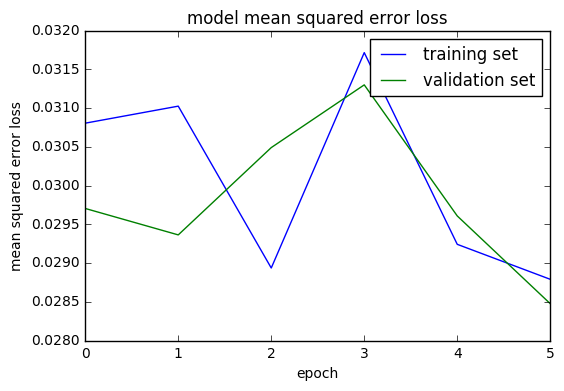

In [42]:
print(history.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

## Explanation

At one point I tried to gaussian fit my data via angle distributions. Attempting this was a brutal task and I spent many many hours on it

### Data Acquisition

### Preprocessing

### Arrays vs Dataframes

I had multiple implementations of this program. One was using numpy arrays, and the other is using dataframes. When I was using numpy arrays I had no way to nicely sort the center_turns, left_turns, and right_turns from each other because I simply concatenated them together into one large training array. I soon realized needed to separate each turn type in order to add more of some turns to balance out the histogram of steering angles. I had so many angles ~0 degrees (which is just the car going straight). Pandas dataframes were a great options for this. 

Originally I was just pushing all the images into an array, adding a correction factor to the left_cam images and subtracting a correction factor from the right images. However this was extremely inefficient. After choosing the pandas DataFrame method I was able to add the correction factor to left_camera and right_camera images on the fly and send them through the preprocessing pipeline

### Generating Batches
I chose to generate batches of my training data instead of yielding a single image each time so I have more control on the distribution of what gets yielded. If I was yielding an image each time, I would increase my `samples_per_epoch` in my `train_generator` to be equal to the number of sample images in my dataset. This way I simply make that a lower number and yield batches. Yielding batches also helps to avoid possible errors if I attempted to control the distribution of center_cam, left_cam, and right_cam images via probability

##### Method 1:
I already created additional data for each center_turn, left_turn, and right_turn respectively. What I attempted to do in my generator was double my batch size. From 16 to 32. 
* Immediately push in a center_cam processed image
* 66% chance to push in another center_cam image
* 33% chance to push in a left_cam image
* 33% chance to push in a right_cam image
This will allow me to introduce random left and right cam images into the dataset, creating additional data.

#### Method 2:
The second method was to maintain the batch size at 32 images per batch and to create a 33% chance to push a center_cam, left_cam, or right_cam
* 33% chance for center_cam
* 33% chance for left_cam
* 33% chance for right_cam

#### Method 3:
The third method was to maintain a batch size at 32 and only push in center images

#### Method 4:
Increase batch size to 256 and only use center images

### Network Architecture

I chose to use the Nvidia model [https://arxiv.org/pdf/1604.07316v1.pdf]. In the preprocessing stages I converted my image from 160,320,3 to 60, 220, 3 (RGB)
* attempt 1: I attempted to convert the image to HSV and only normalize the S channel. This turned out to [add effect]
* attempt 2: I kept the image as RGB and fed that into the network and performed normalization on all three channels [red, green, blue]

#### Choice 1: Dropout

#### Choice 2: No Dropout

#### ReLu's vs ELu's

### Training

* I used adam optimization and MSE
* I used 20k samples per epoch because I have about 80k images and I do not want to sample the entire set each time

## Getting it to work

Most of this project was experimental. I would get the car to drive, and then run into some sort of wall or something. Then I would start tinkering with the preprocessing stages. I did not modify the network architecture that much other than including a dropout layer so I did not overfit my training data. The dropout layer will help me normalize and generalize to track 2

### RANDOM TEST

### Visualize preprocessing

In [ ]:
# random selection
data = train_data
random_images = []
for i in range(20):
    idx = np.random.randint(len(data))
    row = data.iloc[[idx]].reset_index()
    x, y = preprocess_image_from_path(row['center'].values[0], row['steering'].values[0])
    random_images.append((x, y))
    
plt.figure(figsize=(16, 10))
gs1 = gridspec.GridSpec(4, 5)
gs1.update(wspace = 0.01, hspace = 0.01)
for idx, image in enumerate(random_images):
    angle = 'ang: ' + str(image[1]) 
    ax1 = plt.subplot(gs1[idx])
    ax1.axis('off')
    plt.title(angle)
    plt.imshow(image[0])
plt.show()

In [ ]:
def createTrainingDataPathsCenterLeftRightPrefixGood(df, correction_factor, prefix_path):
    """
    creates training data and training labels/ measurements from a data frame
    inputs:
    df: pandas DataFrame object
    start: starting row to grab data
    end: ending row to grab data
    correction_factor: factor to correct steering angles
    """
    center_images = []
    left_images = []
    right_images = []
    measurements = []
    abs_path_to_IMG = os.path.abspath(prefix_path)
    for idx, row in df.iterrows():
        # center images
        center_images.append(os.path.join(abs_path_to_IMG, row['center'].strip()))
        measurements.append(row['steering'])

        # left images
        left_images.append(os.path.join(abs_path_to_IMG, row['left'].strip()))
        measurements.append(row['steering'] - correction_factor)

        # right images
        right_images.append(os.path.join(abs_path_to_IMG, row['right'].strip()))
        measurements.append(row['steering'] + correction_factor)

    return (np.asarray(center_images), np.asarray(left_images), np.asarray(right_images), np.asarray(measurements, dtype=np.float32))

In [ ]:
def createTrainingDataPathsCLR(df, correction_factor, angle_threshold = 0.15, prefix_path):
    """
    creates training data and training labels/ measurements from a data frame
    inputs:
    df: pandas DataFrame object
    start: starting row to grab data
    end: ending row to grab data
    correction_factor: factor to correct steering angles
    """
    center_images = []
    left_images = []
    right_images = []
    
    center_measurements = []
    left_measurements = []
    right_measurements = []
    
    abs_path_to_IMG = os.path.abspath(prefix_path)
    for idx, row in df.iterrows():
        # center images
        center_images.append(os.path.join(abs_path_to_IMG, row['center'].strip()))
        center_measurements.append(row['steering'])


        # left images
        left_images.append(os.path.join(abs_path_to_IMG, row['left'].strip()))
        left_measurements.append(row['steering'] - correction_factor)

        # right images
        right_images.append(os.path.join(abs_path_to_IMG, row['right'].strip()))
        right_measurements.append(row['steering'] + correction_factor)
            
    return (
        np.asarray(center_images),
        np.asarray(left_images),
        np.asarray(right_images),
        np.asarray(center_measurements, dtype=np.float32),
        np.asarray(left_measurements, dtype=np.float32),
        np.asarray(right_measurements, dtype=np.float32),
    )

In [ ]:
def removeZerosFromCenter(X, y, rang = 0.1):
    low = -1 * rang
    high = rang
    is_y_in_range = np.logical_or(y <= low, y >= high)
    X = X[is_y_in_range]
    y = y[is_y_in_range]
    return X,y

In [ ]:
def removeZerosFromLeft(X, y, correction_factor, rang = 0.1):
    low = -1 * (correction_factor + rang)
    high = -1 * (correction_factor - rang)
    is_y_in_range = np.logical_or(y <= low, y >= high)
    X = X[is_y_in_range]
    y = y[is_y_in_range]
    return X, y

In [ ]:
def removeZerosFromRight(X, y, correction_factor, rang = 0.1):
    high = correction_factor + rang
    low = correction_factor - rang
    is_y_range = np.logical_or(y <= low, y >= high)
    X = X[is_y_range]
    y = y[is_y_range]
    return X, y

### Create data from udacity

In [ ]:
data_pd_cw2 = createDataFrame('data/driving_log.csv')
X_train_cw2_c, X_train_cw2_l, X_train_cw2_r, y_train_cw2 = createTrainingDataPathsCenterLeftRightPrefixGood(data_pd_cw2, cf, 'data/')
# data_pd_cw2.hist(column = 'throttle')
X_train_udacity = np.append(X_train_cw2_c, X_train_cw2_l, axis = 0)
X_train_udacity = np.append(X_train_udacity, X_train_cw2_r, axis = 0)
y_train_udacity = y_train_cw2
print('shape of X_train_udacity: ', X_train_udacity.shape)
print('shape of y_train_udacity: ', y_train_udacity.shape)

In [ ]:
# Create more udacity data 
(X_train_cw2_c, 
X_train_cw2_l, 
X_train_cw2_r, 
y_train_cw2_c,
y_train_cw2_l,
y_train_cw2_r) = createTrainingDataPathsCLR(data_pd_cw2, 0.15, 'data/')

In [ ]:
print('X_train_cw2_c shape: ', X_train_cw2_c.shape)
print('y_train_cw2_c shape: ', y_train_cw2_c.shape)
print('y_train_cw2_l shape: ', X_train_cw2_l.shape)
print('X_train_cw2_l shape: ', y_train_cw2_l.shape)
print('X_train_cw2_r shape: ', X_train_cw2_r.shape)
print('y_train_cw2_r shape: ', y_train_cw2_r.shape)

In [ ]:
X_train_cw2_c, y_train_cw2_c = removeZerosFromCenter(X_train_cw2_c, y_train_cw2_c)
X_train_cw2_l, y_train_cw2_l = removeZerosFromLeft(X_train_cw2_l, y_train_cw2_l, cf)
X_train_cw2_r, y_train_cw2_r = removeZerosFromRight(X_train_cw2_r, y_train_cw2_r, cf)

print('X_train_cw2_c shape: ', X_train_cw2_c.shape)
print('y_train_cw2_c shape: ', y_train_cw2_c.shape)
print('y_train_cw2_l shape: ', X_train_cw2_l.shape)
print('X_train_cw2_l shape: ', y_train_cw2_l.shape)
print('X_train_cw2_r shape: ', X_train_cw2_r.shape)
print('y_train_cw2_r shape: ', y_train_cw2_r.shape)
X_train_udacity_2 = np.append(X_train_cw2_c, X_train_cw2_l, axis = 0)
X_train_udacity_2 = np.append(X_train_udacity_2, X_train_cw2_r, axis = 0)
print('X_train_udacity_2 shape: ', X_train_udacity_2.shape)
y_train_udacity_2 = np.append(y_train_cw2_c, y_train_cw2_l, axis = 0)
y_train_udacity_2 = np.append(y_train_udacity_2, y_train_cw2_r, axis = 0)
print('y_train_udacity_2 shape: ', y_train_udacity_2.shape)

Add original udacity data to filtered udacity data

In [ ]:
X_train_udacity = np.append(X_train_udacity, X_train_udacity_2, axis = 0)
y_train_udacity = np.append(y_train_udacity, y_train_udacity_2, axis = 0)

### Create data from annie recovery

In [ ]:
data_pd_cwr2 = createDataFrame('annie_recovery/driving_log_recovery.csv')

In [ ]:
(X_train_cwr2_c, 
X_train_cwr2_l, 
X_train_cwr2_r, 
y_train_cwr2_c,
y_train_cwr2_l,
y_train_cwr2_r) = createTrainingDataPathsCLR(data_pd_cwr2, 0.15, 'annie_recovery/')

X_train_cwr2_c, y_train_cwr2_c = removeZerosFromCenter(X_train_cwr2_c, y_train_cwr2_c)
X_train_cwr2_l, y_train_cwr2_l = removeZerosFromLeft(X_train_cwr2_l, y_train_cwr2_l, cf)
X_train_cwr2_r, y_train_cwr2_r = removeZerosFromRight(X_train_cwr2_r, y_train_cwr2_r, cf)

print('X_train_cwr2_c shape: ', X_train_cwr2_c.shape)
print('y_train_cwr2_c shape: ', y_train_cwr2_c.shape)
print('y_train_cwr2_l shape: ', X_train_cwr2_l.shape)
print('X_train_cwr2_l shape: ', y_train_cwr2_l.shape)
print('X_train_cwr2_r shape: ', X_train_cwr2_r.shape)
print('y_train_cwr2_r shape: ', y_train_cwr2_r.shape)

In [ ]:
print('X_train_cwr2_c shape: ', X_train_cwr2_c.shape)
print('y_train_cwr2_c shape: ', y_train_cwr2_c.shape)
print('y_train_cwr2_l shape: ', X_train_cwr2_l.shape)
print('X_train_cwr2_l shape: ', y_train_cwr2_l.shape)
print('X_train_cwr2_r shape: ', X_train_cwr2_r.shape)
print('y_train_cwr2_r shape: ', y_train_cwr2_r.shape)

In [ ]:
X_train_annie = np.append(X_train_cwr2_c, X_train_cwr2_l, axis = 0)
X_train_annie = np.append(X_train_annie, X_train_cwr2_r, axis = 0)
print('X_train_cwr2 shape: ', X_train_annie.shape)
y_train_annie = np.append(y_train_cwr2_c, y_train_cwr2_l, axis = 0)
y_train_annie = np.append(y_train_annie, y_train_cwr2_r, axis = 0)
print('y_train_cwr2 shape: ', y_train_annie.shape)

### To demonstrate acquisition function in other file and to check its correctness

In [ ]:
X_train = np.append(X_train_udacity, X_train_annie, axis = 0)
y_train = np.append(y_train_udacity, y_train_annie, axis = 0)

### Create data from dirt recovery (ccw)

In [ ]:
data_pd_dirt_c1 = createDataFrame('A_Recovery_right_lane_dirt/driving_log.csv')

In [ ]:
(X_train_dirt_c1_c, 
X_train_dirt_c1_l, 
X_train_dirt_c1_r, 
y_train_dirt_c1_c,
y_train_dirt_c1_l,
y_train_dirt_c1_r) = createTrainingDataPathsCLR(data_pd_dirt_c1, cf, '.')

In [ ]:
print('X_train_dirt_c1_c shape: ', X_train_dirt_c1_c.shape)
print('y_train_dirt_c1_c shape: ', y_train_dirt_c1_c.shape)
print('y_train_dirt_c1_l shape: ', X_train_dirt_c1_l.shape)
print('X_train_dirt_c1_l shape: ', y_train_dirt_c1_l.shape)
print('X_train_dirt_c1_r shape: ', X_train_dirt_c1_r.shape)
print('y_train_dirt_c1_r shape: ', y_train_dirt_c1_r.shape)

remove steering data with zeros

In [ ]:
print(cf)

In [ ]:
X_train_dirt_c1_c, y_train_dirt_c1_c = removeZerosFromCenter(X_train_dirt_c1_c, y_train_dirt_c1_c)
X_train_dirt_c1_l, y_train_dirt_c1_l = removeZerosFromLeft(X_train_dirt_c1_l, y_train_dirt_c1_l, cf)
X_train_dirt_c1_r, y_train_dirt_c1_r = removeZerosFromRight(X_train_dirt_c1_r, y_train_dirt_c1_r, cf)

In [ ]:
print('X_train_dirt_c1_c shape: ', X_train_dirt_c1_c.shape)
print('y_train_dirt_c1_c shape: ', y_train_dirt_c1_c.shape)
print('y_train_dirt_c1_l shape: ', X_train_dirt_c1_l.shape)
print('X_train_dirt_c1_l shape: ', y_train_dirt_c1_l.shape)
print('X_train_dirt_c1_r shape: ', X_train_dirt_c1_r.shape)
print('y_train_dirt_c1_r shape: ', y_train_dirt_c1_r.shape)

append them together

In [ ]:
X_train_dirt_c1 = np.append(X_train_dirt_c1_c, X_train_dirt_c1_l, axis = 0)
X_train_dirt_c1 = np.append(X_train_dirt_c1, X_train_dirt_c1_r, axis = 0)
print('X_train_dirt_c1 shape: ', X_train_dirt_c1.shape)
y_train_dirt_c1 = np.append(y_train_dirt_c1_c, y_train_dirt_c1_l, axis = 0)
y_train_dirt_c1 = np.append(y_train_dirt_c1, y_train_dirt_c1_r, axis = 0)
print('y_train_dirt_c1 shape: ', y_train_dirt_c1.shape)

### <font color='green'>=> X_train_dirt_c1, y_train_dirt_c1</font>

### Create data from recovery_by_lake_1 (cw)

In [ ]:
data_pd_lake_c1 = createDataFrame('recovery_cw_bylake/driving_log.csv')

In [ ]:
(X_train_lake_c1_c, 
X_train_lake_c1_l, 
X_train_lake_c1_r, 
y_train_lake_c1_c,
y_train_lake_c1_l,
y_train_lake_c1_r) = createTrainingDataPathsCLR(data_pd_lake_c1, cf, '.')

remove steering data with zeros

In [ ]:
X_train_lake_c1_c, y_train_lake_c1_c = removeZerosFromCenter(X_train_lake_c1_c, y_train_lake_c1_c)
X_train_lake_c1_l, y_train_lake_c1_l = removeZerosFromLeft(X_train_lake_c1_l, y_train_lake_c1_l, cf)
X_train_lake_c1_r, y_train_lake_c1_r = removeZerosFromRight(X_train_lake_c1_r, y_train_lake_c1_r, cf)

In [ ]:
print('X_train_lake_c1_c shape: ', X_train_lake_c1_c.shape)
print('y_train_lake_c1_c shape: ', y_train_lake_c1_c.shape)
print('y_train_lake_c1_l shape: ', X_train_lake_c1_l.shape)
print('X_train_lake_c1_l shape: ', y_train_lake_c1_l.shape)
print('X_train_lake_c1_r shape: ', X_train_lake_c1_r.shape)
print('y_train_lake_c1_r shape: ', y_train_lake_c1_r.shape)

append them together

In [ ]:
X_train_lake_c1 = np.append(X_train_lake_c1_c, X_train_lake_c1_l, axis = 0)
X_train_lake_c1 = np.append(X_train_lake_c1, X_train_lake_c1_r, axis = 0)
print('X_train_lake_c1 shape: ', X_train_lake_c1.shape)
y_train_lake_c1 = np.append(y_train_lake_c1_c, y_train_lake_c1_l, axis = 0)
y_train_lake_c1 = np.append(y_train_lake_c1, y_train_lake_c1_r, axis = 0)
print('y_train_lake_c1 shape: ', y_train_lake_c1.shape)

### <font color='green'>=> X_train_lake_c1, y_train_lake_c1</font>

### Create data from recovery_by_lake_cw_2

In [ ]:
data_pd_lake_c2 = createDataFrame('recovery_cw_by_lake_2/driving_log.csv')

In [ ]:
(X_train_lake_c2_c, 
X_train_lake_c2_l, 
X_train_lake_c2_r, 
y_train_lake_c2_c,
y_train_lake_c2_l,
y_train_lake_c2_r) = createTrainingDataPathsCLR(data_pd_lake_c2, cf, '.')

remove steering data with zeros

In [ ]:
X_train_lake_c2_c, y_train_lake_c2_c = removeZerosFromCenter(X_train_lake_c2_c, y_train_lake_c2_c)
X_train_lake_c2_l, y_train_lake_c2_l = removeZerosFromLeft(X_train_lake_c2_l, y_train_lake_c2_l, cf)
X_train_lake_c2_r, y_train_lake_c2_r = removeZerosFromRight(X_train_lake_c2_r, y_train_lake_c2_r, cf)

In [ ]:
print('X_train_lake_c2_c shape: ', X_train_lake_c2_c.shape)
print('y_train_lake_c2_c shape: ', y_train_lake_c2_c.shape)
print('y_train_lake_c2_l shape: ', X_train_lake_c2_l.shape)
print('X_train_lake_c2_l shape: ', y_train_lake_c2_l.shape)
print('X_train_lake_c2_r shape: ', X_train_lake_c2_r.shape)
print('y_train_lake_c2_r shape: ', y_train_lake_c2_r.shape)

append them together

In [ ]:
X_train_lake_c2 = np.append(X_train_lake_c2_c, X_train_lake_c2_l, axis = 0)
X_train_lake_c2 = np.append(X_train_lake_c2, X_train_lake_c2_r, axis = 0)
print('X_train_lake_c2 shape: ', X_train_lake_c2.shape)
y_train_lake_c2 = np.append(y_train_lake_c2_c, y_train_lake_c2_l, axis = 0)
y_train_lake_c2 = np.append(y_train_lake_c2, y_train_lake_c2_r, axis = 0)
print('y_train_lake_c2 shape: ', y_train_lake_c2.shape)

### <font color='green'>=> X_train_lake_c2, y_train_lake_c2</font>

### Create data from ken dirt recovery_set1 (dirt2)

In [ ]:
data_pd_dirt2_cw = createDataFrame('controller_dirt_track1_set1_cw/driving_log.csv')

In [ ]:
(X_train_dirt2_cw_c, 
X_train_dirt2_cw_l, 
X_train_dirt2_cw_r, 
y_train_dirt2_cw_c,
y_train_dirt2_cw_l,
y_train_dirt2_cw_r) = createTrainingDataPathsCLR(data_pd_dirt2_cw, 0.15, 'controller_dirt_track1_set1_cw/')

X_train_dirt2_cw_c, y_train_dirt2_cw_c = removeZerosFromCenter(X_train_dirt2_cw_c, y_train_dirt2_cw_c)
X_train_dirt2_cw_l, y_train_dirt2_cw_l = removeZerosFromLeft(X_train_dirt2_cw_l, y_train_dirt2_cw_l, cf)
X_train_dirt2_cw_r, y_train_dirt2_cw_r = removeZerosFromRight(X_train_dirt2_cw_r, y_train_dirt2_cw_r, cf)

print('X_train_dirt2_cw_c shape: ', X_train_dirt2_cw_c.shape)
print('y_train_dirt2_cw_c shape: ', y_train_dirt2_cw_c.shape)
print('y_train_dirt2_cw_l shape: ', X_train_dirt2_cw_l.shape)
print('X_train_dirt2_cw_l shape: ', y_train_dirt2_cw_l.shape)
print('X_train_dirt2_cw_r shape: ', X_train_dirt2_cw_r.shape)
print('y_train_dirt2_cw_r shape: ', y_train_dirt2_cw_r.shape)

X_train_dirt2_cw = np.append(X_train_dirt2_cw_c, X_train_dirt2_cw_l, axis = 0)
X_train_dirt2_cw = np.append(X_train_dirt2_cw, X_train_dirt2_cw_r, axis = 0)
print('X_train_dirt2_cw shape: ', X_train_dirt2_cw.shape)
y_train_dirt2_cw = np.append(y_train_dirt2_cw_c, y_train_dirt2_cw_l, axis = 0)
y_train_dirt2_cw = np.append(y_train_dirt2_cw, y_train_dirt2_cw_r, axis = 0)
print('y_train_dirt2_cw shape: ', y_train_dirt2_cw.shape)

### <font color='green'>=> X_train_dirt2_cw, y_train_dirt2_cw</font>#

### Create data from ken dirt recovery_set2 (dirt3)

In [ ]:
data_pd_dirt3_cw = createDataFrame('controller_dirt_track1_set2_cw/driving_log.csv')

In [ ]:
(X_train_dirt3_cw_c, 
X_train_dirt3_cw_l, 
X_train_dirt3_cw_r, 
y_train_dirt3_cw_c,
y_train_dirt3_cw_l,
y_train_dirt3_cw_r) = createTrainingDataPathsCLR(data_pd_dirt3_cw, 0.15, 'controller_dirt_track1_set2_cw/')

X_train_dirt3_cw_c, y_train_dirt3_cw_c = removeZerosFromCenter(X_train_dirt3_cw_c, y_train_dirt3_cw_c)
X_train_dirt3_cw_l, y_train_dirt3_cw_l = removeZerosFromLeft(X_train_dirt3_cw_l, y_train_dirt3_cw_l, cf)
X_train_dirt3_cw_r, y_train_dirt3_cw_r = removeZerosFromRight(X_train_dirt3_cw_r, y_train_dirt3_cw_r, cf)

print('X_train_dirt3_cw_c shape: ', X_train_dirt3_cw_c.shape)
print('y_train_dirt3_cw_c shape: ', y_train_dirt3_cw_c.shape)
print('y_train_dirt3_cw_l shape: ', X_train_dirt3_cw_l.shape)
print('X_train_dirt3_cw_l shape: ', y_train_dirt3_cw_l.shape)
print('X_train_dirt3_cw_r shape: ', X_train_dirt3_cw_r.shape)
print('y_train_dirt3_cw_r shape: ', y_train_dirt3_cw_r.shape)

X_train_dirt3_cw = np.append(X_train_dirt3_cw_c, X_train_dirt3_cw_l, axis = 0)
X_train_dirt3_cw = np.append(X_train_dirt3_cw, X_train_dirt3_cw_r, axis = 0)
print('X_train_dirt3_cw shape: ', X_train_dirt3_cw.shape)
y_train_dirt3_cw = np.append(y_train_dirt3_cw_c, y_train_dirt3_cw_l, axis = 0)
y_train_dirt3_cw = np.append(y_train_dirt3_cw, y_train_dirt3_cw_r, axis = 0)
print('y_train_dirt3_cw shape: ', y_train_dirt3_cw.shape)

### Create data from turn before bridge

In [ ]:
data_pd_bridge = createDataFrame('turn_before_bridge/driving_log.csv')

In [ ]:
(X_train_bridge_c, 
X_train_bridge_l, 
X_train_bridge_r, 
y_train_bridge_c,
y_train_bridge_l,
y_train_bridge_r) = createTrainingDataPathsCLR(data_pd_bridge, 0.15, '.')

X_train_bridge_c, y_train_bridge_c = removeZerosFromCenter(X_train_bridge_c, y_train_bridge_c)
X_train_bridge_l, y_train_bridge_l = removeZerosFromLeft(X_train_bridge_l, y_train_bridge_l, cf)
X_train_bridge_r, y_train_bridge_r = removeZerosFromRight(X_train_bridge_r, y_train_bridge_r, cf)

print('X_train_bridge_c shape: ', X_train_bridge_c.shape)
print('y_train_bridge_c shape: ', y_train_bridge_c.shape)
print('y_train_bridge_l shape: ', X_train_bridge_l.shape)
print('X_train_bridge_l shape: ', y_train_bridge_l.shape)
print('X_train_bridge_r shape: ', X_train_bridge_r.shape)
print('y_train_bridge_r shape: ', y_train_bridge_r.shape)

X_train_bridge = np.append(X_train_bridge_c, X_train_bridge_l, axis = 0)
X_train_bridge = np.append(X_train_bridge, X_train_bridge_r, axis = 0)
print('X_train_bridge shape: ', X_train_bridge.shape)
y_train_bridge = np.append(y_train_bridge_c, y_train_bridge_l, axis = 0)
y_train_bridge = np.append(y_train_bridge, y_train_bridge_r, axis = 0)
print('y_train_cwr2 shape: ', y_train_bridge.shape)

### <font color='green'>=> X_train_dirt3_cw, y_train_dirt3_cw</font>#